# Entregable 3 - Modelo de predicción de hábitos de consumo

El objetivo de este entregable fue generar un modelo de estimación de hábitos de consumo para suministros que carezcan de medidores inteligentes. Para ello se utilizó un modelo de predicción de series temporales con componente de estacionalidad, incorporando información de variables exógenas (SARIMAX).

## Carga de librerías y archivos

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#file_path = '/content/drive/My Drive/00 - Diplodatos/Diplodatos desde 2704/modelo_epec.csv'
#final_df = pd.read_csv(file_path, sep=';')

Mounted at /content/drive


In [3]:
# Cargar previamente modelo_epec.csv en la sesión de Google Colab
final_df = pd.read_csv('modelo_epec.csv', sep=';')

## Preparación de los datos

A modo de síntesis de lo trabajado en los entregables 1 y 2, se llegó a la creación del dataset modelo_epec.csv con datos de consumo y otras variables de interés (grupos tarifarios, información climática, información geoespacial, información temporal -día de la semana y día hábil/no hábil-, entre otras).

En base a lo analizado en los entregables pasados, se determinó que las variables que aportaban al comportamiento del consumo eran pricipalmente las relacionadas a los grupos tarifarios y a la temperatura. En base a esto, estas variables fueron las utilizadas como eje en este entregable.

In [7]:
with pd.option_context('display.max_columns', None):
    print(final_df.head())

   DEVICE          TV  consumo  consumo_pico  consumo_valle  consumo_resto  \
0     0.0  2023-01-02    4.508         1.064          1.521          1.923   
1     0.0  2023-01-03    3.803         0.906          1.000          1.897   
2     0.0  2023-01-04    3.837         0.922          0.908          2.007   
3     0.0  2023-01-05    3.648         0.852          0.957          1.839   
4     0.0  2023-01-06    4.218         0.938          1.038          2.242   

   Maxima_Demanda  Dia_Consumo  Semana_Consumo  Mes_Consumo  is_business_day  \
0           0.484          0.0               1          1.0              1.0   
1           0.516          1.0               1          1.0              1.0   
2           0.592          2.0               1          1.0              1.0   
3           0.592          3.0               1          1.0              1.0   
4           0.592          4.0               1          1.0              1.0   

   precipitaciones  temperatura_min  temperatura_m

<ipython-input-55-6447a3609471>:8: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(x="TV", y="consumo",


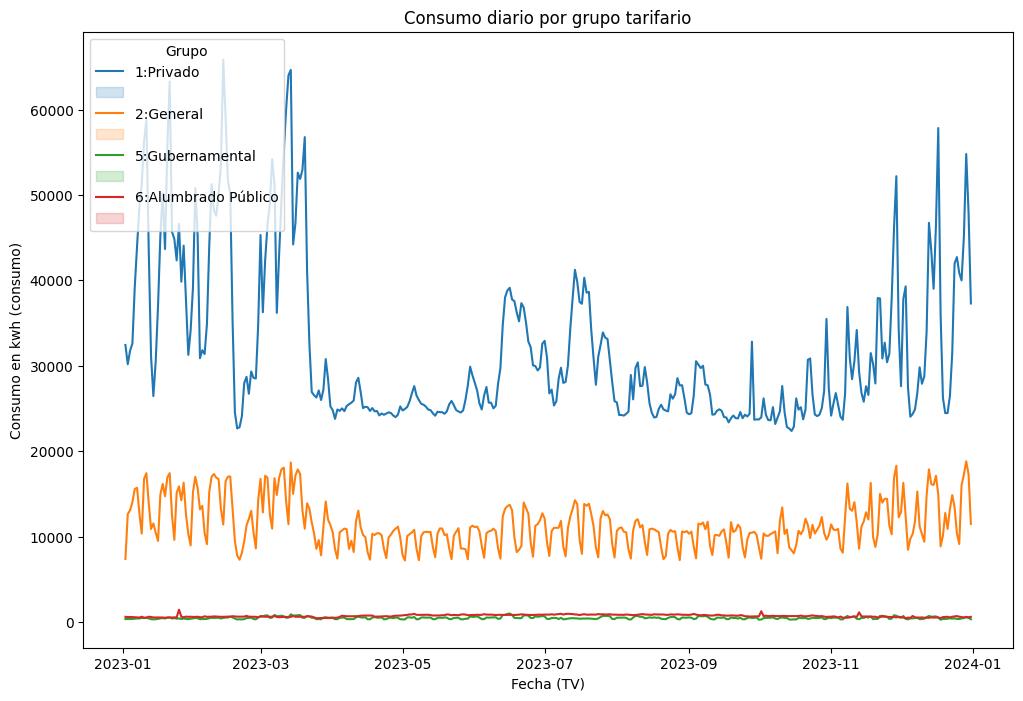

In [55]:
# Consumo diario por grupo tarifario
consumo_grupo_tarifario = final_df.groupby(['TV','grupo_tarifario','temperatura_max','temperatura_min','temperatura_avg','precipitaciones','Dia_Consumo','Mes_Consumo','is_business_day','emae'], as_index=False)[['consumo','Maxima_Demanda']].sum()
consumo_grupo_tarifario['TV'] = pd.to_datetime(consumo_grupo_tarifario['TV'], format='%Y-%m-%d')

fig, ax = plt.subplots(figsize=(12, 8))

# Target: Consumo
sns.lineplot(x="TV", y="consumo",
             hue="grupo_tarifario",
             data=consumo_grupo_tarifario, palette=sns.color_palette())

# Referencias
ax.set(xlabel='Fecha (TV)',
       ylabel='Consumo en kwh (consumo)',
       title='Consumo diario por grupo tarifario')
plt.legend(title='Grupo', loc='upper left', labels=['1:Privado', '','2:General','', '5:Gubernamental', '','6:Alumbrado Público',''])
plt.show()

En relación a los grupos tarifarios, se decidió trabajar sólo con el grupo tarifario 1 (privado), el cual abarca el 89% de los medidores con los que el dataset contaba. Los grupos 5 (gubernamental) y 6 (alumbrado público) mostraron un consumo constante en relación a los grupos 1 y 2, por lo que fueron descartados para la preparación del modelo porque su predicción carece de interés. Con respecto al grupo 2 (general), se observó que dentro de este grupo el consumo por medidor presentaba alta avriabilidad, por lo que por cuestiones de simplificación también fue excluido del análisis.


In [60]:
total_unique_devices = final_df['DEVICE'].nunique()

grupo_1_devices = final_df[final_df['grupo_tarifario'] == 1]
grupo_2_devices = final_df[final_df['grupo_tarifario'] == 2]
grupo_5_devices = final_df[final_df['grupo_tarifario'] == 5]
grupo_6_devices = final_df[final_df['grupo_tarifario'] == 6]

unique_devices_grupo_1 = grupo_1_devices['DEVICE'].nunique()
unique_devices_grupo_2 = grupo_2_devices['DEVICE'].nunique()
unique_devices_grupo_5 = grupo_5_devices['DEVICE'].nunique()
unique_devices_grupo_6 = grupo_6_devices['DEVICE'].nunique()

print(f"Total number of unique devices: {total_unique_devices}")
print(f"Número de devices en Grupo Tarifario 1: {unique_devices_grupo_1}")
print(f"Número de devices en Grupo Tarifario 1: {unique_devices_grupo_2}")
print(f"Número de devices en Grupo Tarifario 1: {unique_devices_grupo_5}")
print(f"Número de devices en Grupo Tarifario 1: {unique_devices_grupo_6}")

Total number of unique devices: 4751
Número de devices en Grupo Tarifario 1: 4216
Número de devices en Grupo Tarifario 1: 496
Número de devices en Grupo Tarifario 1: 19
Número de devices en Grupo Tarifario 1: 20


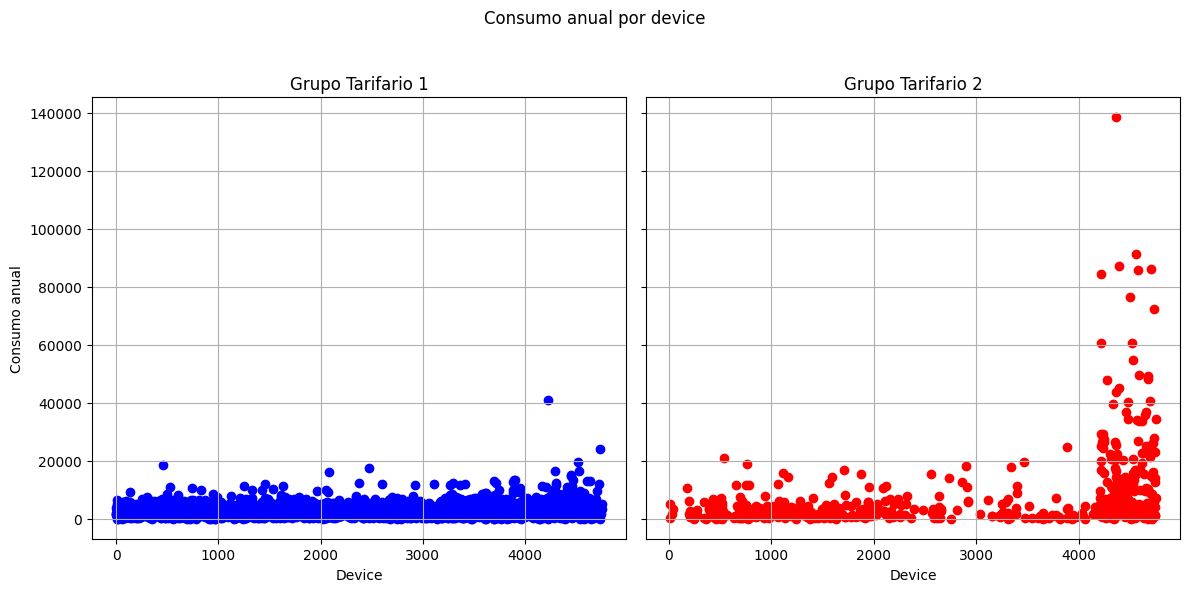

In [61]:
# Consumo anual por device en grupos tarifarios 1 y 2
group_1 = final_df[final_df['grupo_tarifario'] == 1].groupby('DEVICE')['consumo'].sum().reset_index()
group_2 = final_df[final_df['grupo_tarifario'] == 2].groupby('DEVICE')['consumo'].sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scatter plot para grupo 1
axes[0].scatter(group_1['DEVICE'], group_1['consumo'], color='blue')
axes[0].set_title('Grupo Tarifario 1')
axes[0].set_xlabel('Device')
axes[0].set_ylabel('Consumo anual')
axes[0].grid(True)

# Scatter plot para grupo 1
axes[1].scatter(group_2['DEVICE'], group_2['consumo'], color='red')
axes[1].set_title('Grupo Tarifario 2')
axes[1].set_xlabel('Device')
axes[1].grid(True)

plt.suptitle('Consumo anual por device')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


In [12]:
# Se genera dataframe de Grupo Tarifario 1 y se eliminan las columnas que no serán analizadas en este trabajo
grupo_1_df = final_df[final_df['grupo_tarifario'] == 1].copy()

columns_to_drop = [
    'Maxima_Demanda', 'Dia_Consumo', 'Semana_Consumo', 'Mes_Consumo',
    'is_business_day', 'precipitaciones', 'distribuidor', 'subestacion',
    'distrito', 'grupo_tarifario', 'tarifa', 'emae'
]

grupo_1_df = grupo_1_df.drop(columns=columns_to_drop)

In [13]:
grupo_1_df.head()

,DEVICE,TV,consumo,consumo_pico,consumo_valle,consumo_resto,temperatura_min,temperatura_max,temperatura_avg
0,0.0,2023-01-02,4.508,1.064,1.521,1.923,15.0,32.1,24.5
1,0.0,2023-01-03,3.803,0.906,1.000,1.897,18.0,31.5,24.5
2,0.0,2023-01-04,3.837,0.922,0.908,2.007,17.5,33.5,26.1
3,0.0,2023-01-05,3.648,0.852,0.957,1.839,18.0,35.5,27.5
4,0.0,2023-01-06,4.218,0.938,1.038,2.242,19.8,36.7,28.8


Al evaluar la integridad de los datos del grupo 1, se determino que era necesario realizar pasos adicionales de limpieza y curación para que los datos fueran aptos para la generación del modelo de predicción. En particular, se eliminaron aquellos medidores considerados outliers por sus valores de consumo anual, de acuerdo al siguiente gráfico.

En el siguiente gráfico, cada bin representa un intervalo de 100 kW de consumo anual. Se observa que la distribución se aleja de la normalidad debido a aquellos medidores con un consumo anual menor a 700 kW o con consumo anual mayor a 8000 kW.

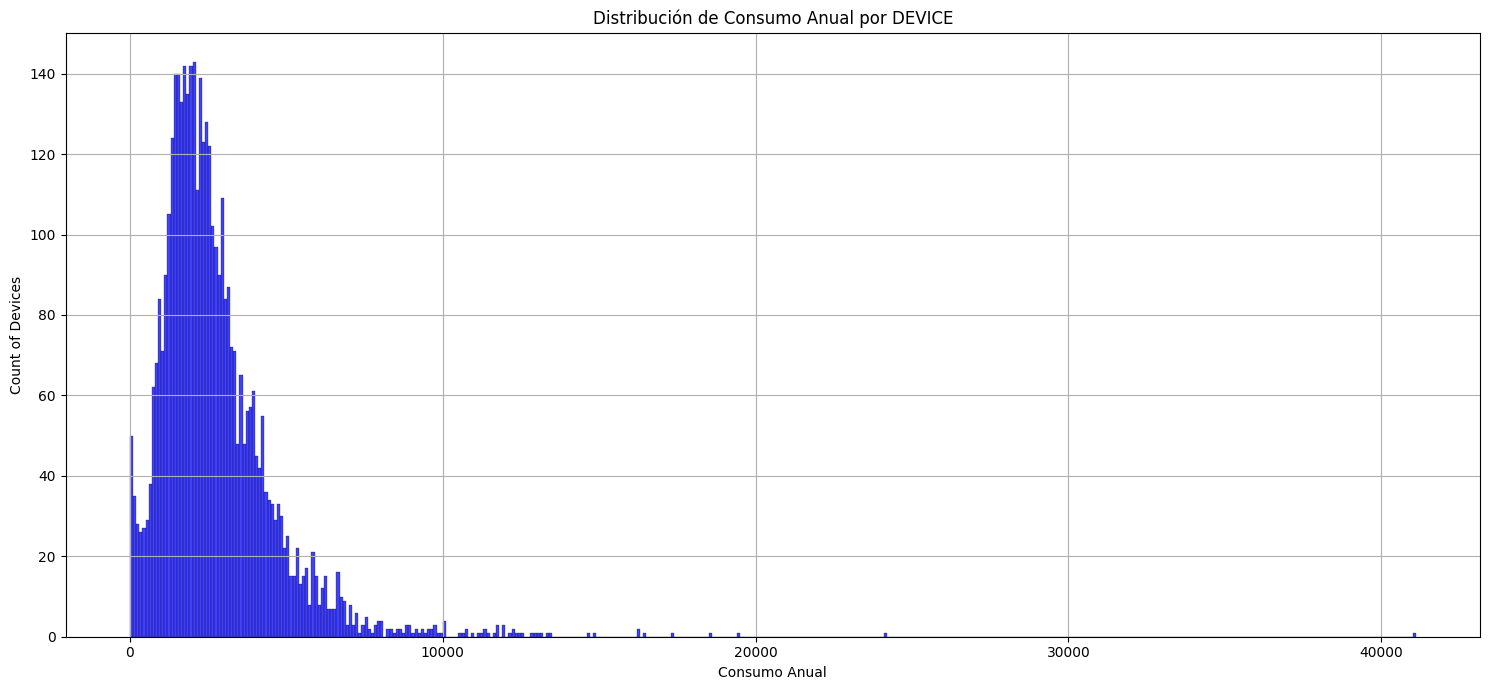

In [62]:
# Distribución de consumo anual por device
consumo_sums = grupo_1_df.groupby('DEVICE')['consumo'].sum().reset_index()

bin_edges = range(0, int(consumo_sums['consumo'].max()) + 100, 100)

plt.figure(figsize=(15, 7))
sns.histplot(consumo_sums['consumo'], bins=bin_edges, kde=False, color='blue')

plt.title('Distribución de Consumo Anual por DEVICE')
plt.xlabel('Consumo Anual')
plt.ylabel('Count of Devices')
plt.grid(True)
plt.tight_layout()

plt.show()

In [22]:
# Creación de dataframe filtrado
consumo_sums = grupo_1_df.groupby('DEVICE')['consumo'].sum().reset_index()
valid_devices = consumo_sums[(consumo_sums['consumo'] >= 700) & (consumo_sums['consumo'] < 8000)]['DEVICE']
grupo_1_df_filt = grupo_1_df[grupo_1_df['DEVICE'].isin(valid_devices)]

Comparación del datasets previo y posterior al filtrado.

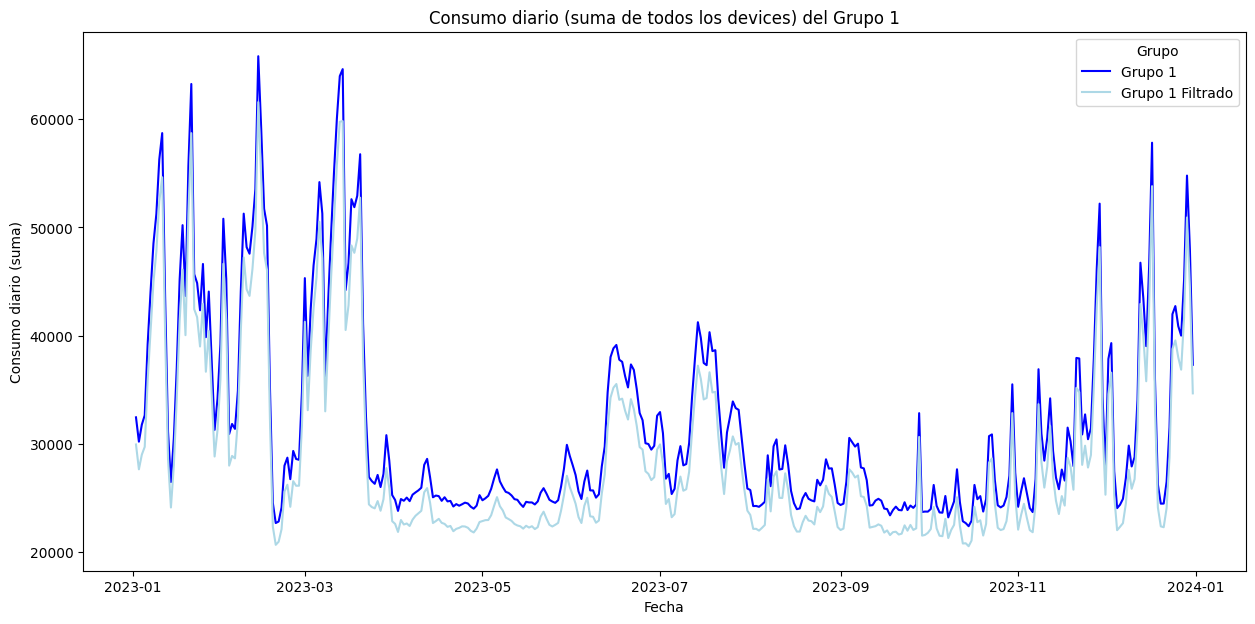

In [26]:
sum_consumo_grupo_1_df = grupo_1_df.groupby('TV')['consumo'].sum().reset_index()
sum_consumo_grupo_1_df['Group'] = 'Grupo 1'

sum_consumo_grupo_1_df_filt = grupo_1_df_filt.groupby('TV')['consumo'].sum().reset_index()
sum_consumo_grupo_1_df_filt['Group'] = 'Grupo 1 Filtrado'

combined_sum_df = pd.concat([sum_consumo_grupo_1_df, sum_consumo_grupo_1_df_filt])
combined_sum_df['TV'] = pd.to_datetime(combined_sum_df['TV'], format='%Y-%m-%d')


plt.figure(figsize=(15, 7))
sns.lineplot(x='TV', y='consumo', hue='Group', data=combined_sum_df, palette={'Grupo 1': 'blue', 'Grupo 1 Filtrado': 'lightblue'})

plt.title('Consumo diario (suma de todos los devices) del Grupo 1')
plt.xlabel('Fecha')
plt.ylabel('Consumo diario (suma)')

plt.legend(title='Grupo')
plt.show()

## Elección del modelo y feature engineering

Mediante el análisis de los datos y la prueba de varios modelos, se llegó a la conclusión de que los datos con los que se disponía representaba una limitante a la hora de los modelos con los que se podía trabajar.

El principal problema es que, al contar sólo con los datos correspondientes a un año calendario, no se está capturando el patrón estacional anual. Por el comportamiento sel consumo observado, difícilmente se pueda predecir el consumo en Noviembre de 2023 si no se cuenta con los datos de Noviembre de 2022, y sólo se cuenta con los datos de Enero a Octubre de 2023. En base a esto se concluyó que se no se puede trabajar con un Modelo Univariado de Series de Tiempo que sólo considere datos de consumo, sino que lo óptimo sería trabajar con un Modelo Multivariado de Series de Tiempo con variables exógenas.

En base a lo observado en los entregables anteriores, se seleccionó como variable exógena la temperatura. No obstante, es posible probar con otras variables exógenas para evaluar otros modelos.

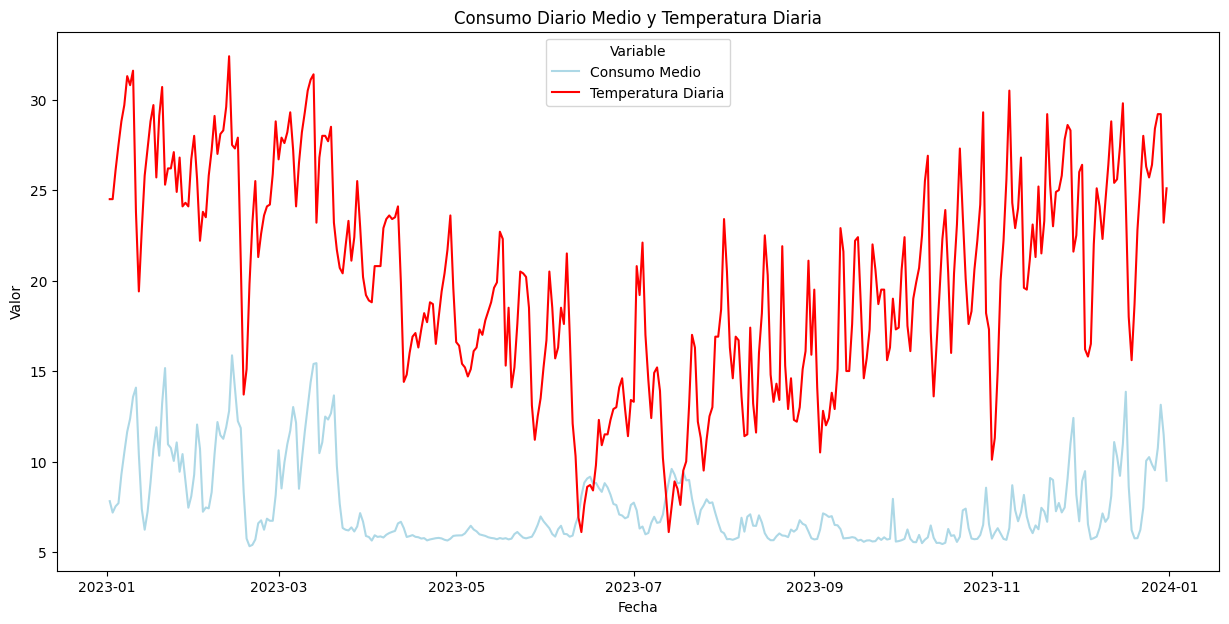

In [63]:
# Gráfico de la media del consumo de cada día y temperatura
mean_consumo = grupo_1_df_filt.groupby('TV')['consumo'].mean().reset_index()
mean_consumo.columns = ['TV', 'consumo_medio']

temperatura_avg = grupo_1_df_filt.groupby('TV')['temperatura_avg'].first().reset_index()

plot_data = mean_consumo.merge(temperatura_avg, on='TV')
plot_data['TV'] = pd.to_datetime(plot_data['TV'], format='%Y-%m-%d')

plt.figure(figsize=(15, 7))

sns.lineplot(x='TV', y='consumo_medio', data=plot_data, color='lightblue', label='Consumo Medio')
sns.lineplot(x='TV', y='temperatura_avg', data=plot_data, color='red', label='Temperatura Diaria')

plt.title('Consumo Diario Medio y Temperatura Diaria')
plt.xlabel('Fecha')
plt.ylabel('Valor')

plt.legend(title='Variable')
plt.show()

En particular, el promedio de la temperatura de un día con los 2 días anteriores, muestra una mayor correlación gráfica con el consumo. Un aspecto central es el hecho de que el comportamiento en relación a la temperatura **se invierte** en el período frío del año (del día 101 al 264 aproximadamente), respecto de los otros días (período cálido) A su vez, el perfil de consumo en el período cálido y el período frío son muy diferentes entre sí, lo que podría ser considerado una pseudoestacionalidad semestral, que el modelo SARIMAX podría reconocer.

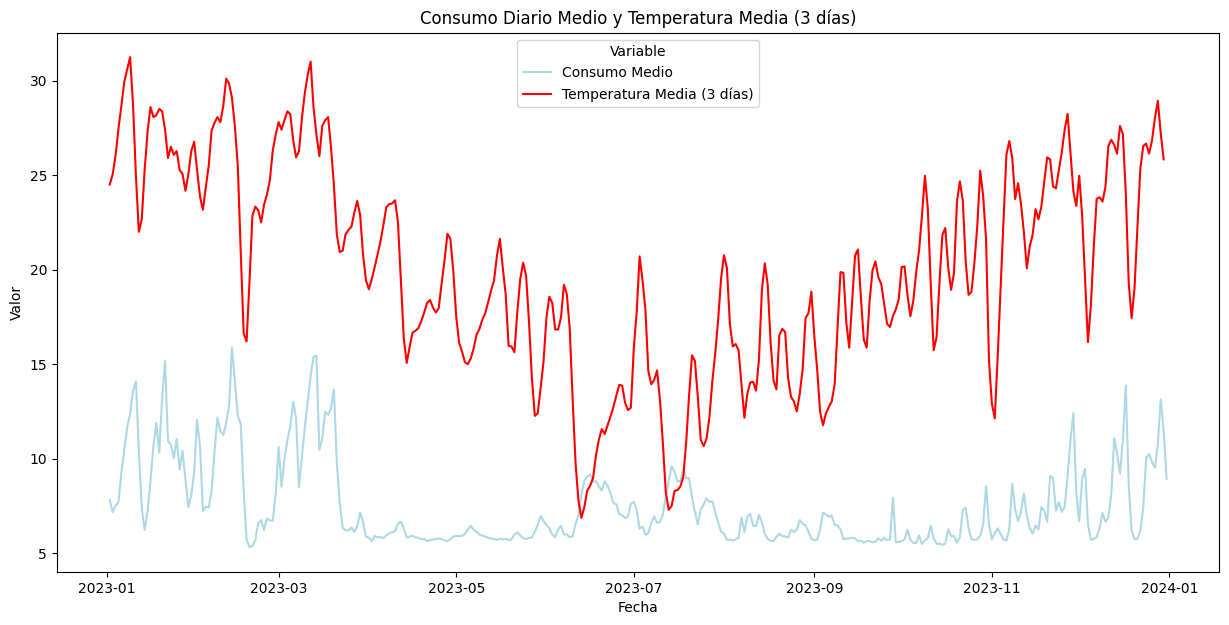

In [64]:
plot_data = mean_consumo.merge(temperatura_avg, on='TV')
plot_data['TV'] = pd.to_datetime(plot_data['TV'], format='%Y-%m-%d')

# Se calcula la media de la temperatura de un día en específico y los 2 días anteriores (Rolling Mean)
plot_data = plot_data.sort_values('TV')
plot_data.set_index('TV', inplace=True)
plot_data['rolling_temp_avg'] = plot_data['temperatura_avg'].rolling(window=3, min_periods=1).mean().shift(-1)

plt.figure(figsize=(15, 7))

sns.lineplot(x=plot_data.index, y=plot_data['consumo_medio'], color='lightblue', label='Consumo Medio')
sns.lineplot(x=plot_data.index, y=plot_data['rolling_temp_avg'], color='red', label='Temperatura Media (3 días)')

plt.title('Consumo Diario Medio y Temperatura Media (3 días)')
plt.xlabel('Fecha')
plt.ylabel('Valor')

plt.legend(title='Variable')
plt.show()

En base a todo esto, se decidió trabajar con un modelo ARIMA estacional con variables exógenas (SARIMAX) usando el promedio de la temperatura media diaria de 3 días como la principal variable exógena. Para proveer información al modelo sobre si se trataba del período frío o del período cálido, se crearon dos términos de interacción capturar el efecto combinado de la temperatura y el período del año. A su vez, se calculó la magnitud del cambio en la temperatura promedio entre días consecutivos, ya que se observó que esto daba cuenta parcialmente de los picos de consumo relacionados a los picos de temperatura. A su vez, debido a que la variable que se intentó predecir es el consumo medio diario, se eliminó la correlación con DEVICE y se dejó una fila por día.

In [46]:
# Aggregate data
df_for_model = grupo_1_df_filt.groupby('TV').agg({
    'consumo': 'mean',
    'consumo_pico': 'mean',
    'consumo_valle': 'mean',
    'consumo_resto': 'mean',
    'temperatura_min': 'first',
    'temperatura_max': 'first',
    'temperatura_avg': 'first'
}).reset_index()

# Convert 'TV' to datetime for further calculations
df_for_model['TV'] = pd.to_datetime(df_for_model['TV'], format='%Y-%m-%d')

# Calculate t_avg_3 (mean of temperatura_avg and the previous two days)
df_for_model.set_index('TV', inplace=True)
df_for_model['t_avg_3'] = df_for_model['temperatura_avg'].rolling(window=3, min_periods=1).mean()

# Reset index to restore 'TV' as a column
df_for_model.reset_index(inplace=True)

# Calculate temperature periods and interaction terms
df_for_model['day_of_year'] = df_for_model['TV'].dt.dayofyear

# Define a function to determine the period
def get_period(day_of_year):
    if day_of_year <= 100 or day_of_year >= 265:
        return 'period_high'
    else:
        return 'period_low'

df_for_model['period'] = df_for_model['day_of_year'].apply(get_period)

# Create interaction terms
df_for_model['temp_period_high'] = df_for_model['temperatura_avg'] * (df_for_model['period'] == 'period_high')
df_for_model['temp_period_low'] = df_for_model['temperatura_avg'] * (df_for_model['period'] == 'period_low')

# Calculate rolling means for interaction terms
df_for_model['temp_period_high_3'] = df_for_model['temp_period_high'].rolling(window=3, min_periods=1).mean()
df_for_model['temp_period_low_3'] = df_for_model['temp_period_low'].rolling(window=3, min_periods=1).mean()

# Step 4: Calculate temperature change magnitude
df_for_model['temp_change_magnitude'] = df_for_model['temperatura_avg'].diff().abs()
df_for_model['temp_change_magnitude'].fillna(0, inplace=True)

In [48]:
df_for_model.head()

,TV,consumo,consumo_pico,consumo_valle,consumo_resto,temperatura_min,temperatura_max,temperatura_avg,t_avg_3,day_of_year,period,temp_period_high,temp_period_low,temp_period_high_3,temp_period_low_3,temp_change_magnitude
0,2023-01-02,7.807649,1.694102,2.092707,4.020840,15.0,32.1,24.5,24.500000,2,period_high,24.5,0.0,24.500000,0.0,0.0
1,2023-01-03,7.176870,1.848364,1.662334,3.666172,18.0,31.5,24.5,24.500000,3,period_high,24.5,0.0,24.500000,0.0,0.0
2,2023-01-04,7.522267,1.746314,1.843900,3.932053,17.5,33.5,26.1,25.033333,4,period_high,26.1,0.0,25.033333,0.0,1.6
3,2023-01-05,7.696574,2.036464,1.777633,3.882477,18.0,35.5,27.5,26.033333,5,period_high,27.5,0.0,26.033333,0.0,1.4
4,2023-01-06,9.281278,2.357150,2.208848,4.715280,19.8,36.7,28.8,27.466667,6,period_high,28.8,0.0,27.466667,0.0,1.3


## Entrenamiento y Evaluación del Modelo SARIMAX

In [49]:
final_df_for_model = df_for_model.copy()

In [50]:
# Se establece la columna 'TV' como índice
final_df_for_model = final_df_for_model.set_index('TV')

Entrenamiento del modelo

El dataset se particionó en train y test en una relación 80:20 (291 y 73 días respectivamente). Los parámetros p, d, q y P, D, Q, s se seleccionaron conforme a la prueba manual de aquellas combinaciones que resultaban en una mejor predicción.

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define split date (the last 73 days)
split_date = final_df_for_model.index[-73]

# Split the data into training and test sets
train = final_df_for_model[final_df_for_model.index < split_date]
test = final_df_for_model[final_df_for_model.index >= split_date]

# Define and fit SARIMAX model on the training set
model = SARIMAX(
    train['consumo'],
    exog=train[['temp_period_high_3', 'temp_period_low_3', 'temp_change_magnitude']],
    order=(3, 1, 0),
    seasonal_order=(1, 0, 1, 4)
)

# Fit the model
sarima_result = model.fit()

# Print the summary of the model
print(sarima_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                             consumo   No. Observations:                  291
Model:             SARIMAX(3, 1, 0)x(1, 0, [1], 4)   Log Likelihood                -373.464
Date:                             Tue, 17 Sep 2024   AIC                            764.928
Time:                                     01:35:39   BIC                            797.957
Sample:                                 01-02-2023   HQIC                           778.161
                                      - 10-19-2023                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
temp_period_high_3        0.2232      0.041      5.490      0.000       0.144       

Evaluación del modelo

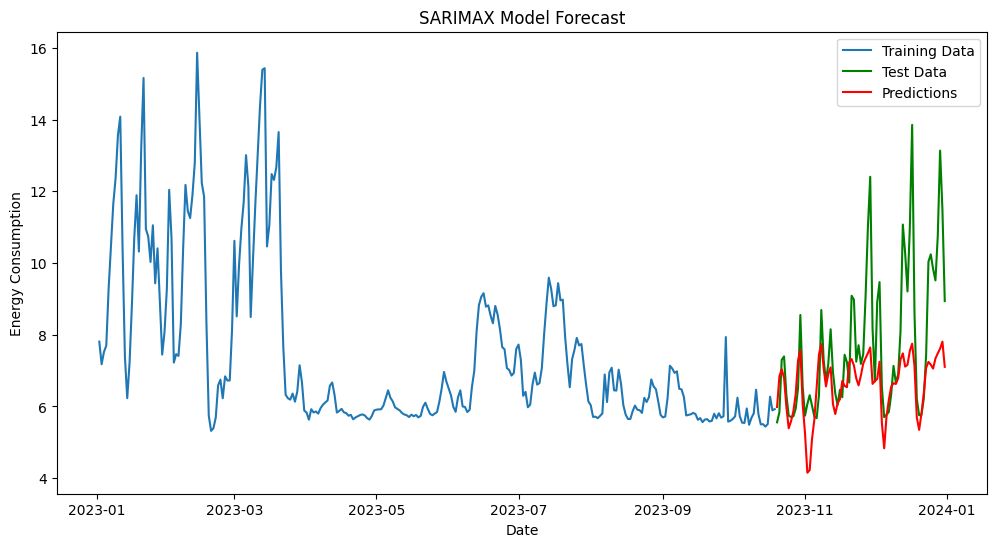

Mean Absolute Error (MAE): 1.2661241248618342
Root Mean Squared Error (RMSE): 1.8424720946681157


In [53]:
# Generate predictions on the test set
test_exog = test[['temp_period_high_3', 'temp_period_low_3', 'temp_change_magnitude']]
predictions = sarima_result.predict(start=test.index[0], end=test.index[-1], exog=test_exog)

# Evaluate the model
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['consumo'], label='Training Data')
plt.plot(test.index, test['consumo'], label='Test Data', color='green')
plt.plot(test.index, predictions, label='Predictions', color='red')
plt.legend()
plt.title('SARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.show()

# Optionally calculate metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), etc.
from sklearn.metrics import mean_squared_error
import numpy as np

mae = np.mean(np.abs(predictions - test['consumo']))
rmse = np.sqrt(mean_squared_error(test['consumo'], predictions))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

De acuerdo a los errores calculados, el valor de consumo predicho se aleja aproximadamente un promedio de 1-2 unidades del valor real (de acuerdo a las magnitudes del consumo, esto representa un error de aproximadamente el 15%). Sin embargo, el gráfico permite identificar que cuanto más agudos son los picos del consumo, peor es la predicción. Esto indica que se debe añadir alguna modificación al modelo que de cuenta de estos cambios abruptos en el consumo para no sub-estimar el consumo en estas circunstancias.

En general, consideramos que este modelo es aceptable para predecir el consumo medio del grupo 1. Las perspectivas a futuro incluyen probar este mismo modelo en datos de devices individuales, y probar nuevas variables exógenas que permitan ajustar la estimación.

## Conclusiones

El modelo es aceptable para una estimación general del consumo. La mejora sustancial de este modelo se daría de contar con datos de un período mayor de tiempo, al menos 1 o 2 años calendario más. En este caso, la variable de temperatura diaria es buena para predecir el consumo. La predicción se pudo mejorar añadiendo información acerca de los períodos "frío" y "cálido". Es posible que la adición de otras variables exógenas permitan predecir con mayor precisión el comportamiento de los picos de consumo.